## 0a) Imports

In [1]:
import sys
sys.path.append("/home/allen/.local/lib/python3.5/site-packages/")

import copy
import datetime
import time
import requests
from bs4 import BeautifulSoup
import math
import random
import trueskill
from IPython.display import clear_output
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle


# 0b) Environment

In [2]:
%matplotlib inline

env = trueskill.TrueSkill(draw_probability = 0.0)
env.make_as_global()

trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.083, draw_probability=0.0%)

# 0c) Utility functions

In [3]:
def get_src_data_paths():
    """ Get the full data path to the src and data directories.

        RETURNS:
        - src_path        (str)          : Path to script directory.
        - data_path       (str)          : Path to data directory.
    """
    src_path = os.getcwd()
    data_path = os.path.dirname(src_path) + os.sep + "data"
    return src_path, data_path

def get_same_names():
    """ Get a dict that maps inconsistent names to just one name.

        RETURNS:
        - same_names      (dict)         : Dict that fixes names.
    """
    # Get original src path and data path.
    src_path, data_path = get_src_data_paths()
    os.chdir(data_path)
    
    # Check if same-names.csv exists.
    if "same-names.csv" in os.listdir(os.getcwd()):
            
        # Create same names dict.
        same_names = {}
        with open("same-names.csv", 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            for name1, name2 in csv_reader:
                same_names[name1] = name2
    
    # Return to original path
    os.chdir(src_path)
    
    return same_names 

def to_str(txt, lower = False):
    """ Convert unicode to str and remove trailing/leading whitespace.

        ARGS:
        - txt              (unicode)     : Result of find() method from lxml.
        - lower            (bool)        : Defaulted to not lowercase.
        
        RETURNS: 
        - str_txt          (str)         : Str object of the text.
    """
    str_txt = txt.text
    str_txt = str_txt.encode("ascii", "ignore")
    str_txt = str_txt.strip()
    if lower:
        str_txt = str_txt.lower()
    return str_txt

def get_ssbm_rank(retro, current, top_N):
    """ Scrapes liquipedia SSBMRank listings.

        ARGS:
        - retro           (str)          : RetroSSBMRank url.
        - current         (str)          : Current SSBMRank url.
        - top_N           (int)          : Maxmimum amount of players.
        
        RETURNS:
        - ssbm_rank       (dict of int)  : Indexed by year, lists of ranks.
    """
    ssbm_rank = {}
    
    # Scrape retro ranks page
    headers = {"User-Agent":"trueskill-smash"}
    retro_html = requests.get(retro, headers = headers).text
    retro_lxml = BeautifulSoup(retro_html,"lxml")
    retro_tables = retro_lxml.find_all("table", {"class":"wikitable"})
    
    # Get retro rankings (2004 to 2012)
    years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
    curr_year_i = 0
    for table in reversed(retro_tables[1:]):
        leaderboards = []
        rows = table.find_all("tr")
        for row in rows[1:]:
            col = row.find_all("td")[1]
            name = to_str(col)
            leaderboards.append(name)
        if leaderboards == []:
            continue
        leaderboards = leaderboards[:top_N]
        ssbm_rank[years[curr_year_i]] = leaderboards
        curr_year_i += 1
        if curr_year_i >= len(years):
            break
            
    # Scrape recent ranks page
    time.sleep(2)
    current_html = requests.get(current, headers = headers).text
    current_lxml = BeautifulSoup(current_html,"lxml")
    c_table = "sortable wikitable"
    tables = current_lxml.find_all("table", {"class":c_table})
    
    # Get recent rankings (2012 - 2018)
    for table in tables:
        leaderboards = []
        title = table.find("th")
        title = to_str(title)
        num_words = title.split(" ")
        if len(num_words) == 3:
            continue
        year = int(num_words[1])
        rows = table.find_all("tr")
        for row in rows[2:]:
            col = row.find_all("td")[2]
            name = to_str(col)
            leaderboards.append(name)
            if len(leaderboards) == top_N:
                break
        ssbm_rank[year] = leaderboards
    
    return ssbm_rank

# 1a) Data scraping (functions)

In [4]:
def scrape_data(tournaments_url):
    """ Scrapes liquipedia tournament listings to create a data set.

        ARGS:
        - tournaments_url (str)          : Liquipedia's tournament list website.
    """
    # Get the table html, where each row is a brief description of a tournament.
    headers = {"User-Agent":"trueskill-smash"}
    tournaments_html = requests.get(tournaments_url, headers = headers).text
    tournaments_lxml = BeautifulSoup(tournaments_html,"lxml")
    c_row = ["divRow", "divRow tournament-card-premier tournament-card-premier"]
    tournament_rows_html = tournaments_lxml.find_all("div", {"class":c_row})
    
    # Fix inconsistent names
    same_names = get_same_names()

    # Process each tournament row's description.
    for tournament_row in tournament_rows_html:

        # Get url to the tournament page
        domain = tournaments_url.split("/smash/")[0]
        tournament_path = tournament_row.find("b").find("a")["href"]
        tournament_url = domain + tournament_path
        
        # Get tournament dict
        tournament = get_tournament(tournament_url, same_names)
        time.sleep(2)
        
        # Don't add invalid/incomplete tournaments.
        if tournament == None:
            continue
            
        # Create tournament directory and csvs.
        create_tournament_dir(tournament, same_names)
        time.sleep(2)
        
def get_tournament(tournament_url, same_names):
    """ Returns a tournament dict from a row in liquipedia's listings.
    
        Each tournament entry will be a dict with the following str keys:
        - "title"         (str)          : Title of the tournament.
        - "date"          (datetime)     : Date the tournament ended.
        - "tier"          (int)          : Higher = more important.
        - "bracket"       (str)          : Bracket page URL.
        
        ARGS:
        - tournament_url  (str)          : Liquipedia's tournament website.
        - same_names      (dict)         : Dict that fixes names.
        
        RETURNS: 
        - tournament      (dict)         : All tournament info.
    """
    # Get the lxml for the entire tournament page.
    headers = {"User-Agent":"trueskill-smash"}
    tournament_html = requests.get(tournament_url, headers = headers).text
    tournament_lxml = BeautifulSoup(tournament_html,"lxml")

    # Only scrape tournaments that ended.
    c_first = "background-color-first-place"
    first_place = tournament_lxml.find("tr", {"class":c_first})
    if first_place == None:
        return None
    c_players = "prizepooltable-player-tag"
    winner = first_place.find("div", {"class":c_players})
    if winner == None:
        return None
    winner = to_str(winner, lower = True)
    if winner == "tbd":
        return None
        
    # Get the title of the tournament.
    c_infobox = "fo-nttax-infobox wiki-bordercolor-light"
    infobox = tournament_lxml.find("div", {"class":c_infobox})
    title = infobox.find("span", {"itemprop":"name"})
    title = to_str(title)
    title = title.replace(",", "")
    
    # Get the date the tournament ended.
    date = tournament_lxml.find("div", {"itemprop":"endDate"})
    if date == None:
        date = tournament_lxml.find("div", {"itemprop":"startDate"})
    date = to_str(date)
    date = datetime.datetime.strptime(date, "%B %d, %Y")
        
    # Get tournament tier, if any.
    tier = 0
    a_list = infobox.find_all("a", {"class":"mw-redirect"})
    for a in a_list:
        a = to_str(a)
        if a == "Premier":
            tier = 2
            break
        if a == "Major":
            tier = 1
            break
            
    # Get a URL to any page that has brackets, if possible.
    c_tabs = "tabs-static"
    tabs_area = tournament_lxml.find_all("div", {"class":c_tabs})
    bracket = None
    if len(tabs_area) > 0:
        tabs = tabs_area[-1].find_all("a", href = True)
        valid_txt = ["singles bracket", "finals bracket"]
        for tab in tabs:
            tab_txt = to_str(tab, lower = True)
            for valid in valid_txt:
                if tab_txt == valid:
                    bracket = tournament_url.split("/smash/")[0] + tab["href"]
    elif len(tournament_lxml.find_all("div", {"class":"bracket-game"})) > 0:
        bracket = tournament_url 
    if bracket == None:
        return None
    
    # Assemble data and create tournament dict.
    tournament = {"title":title, "date":date, "tier":tier, "bracket":bracket}
    
    return tournament


In [5]:
def create_tournament_dir(tournament, same_names):
    """ Create a directory for the tournament and create csv data.
    
        The data structure is organized as the following:
        - /data/yyyy/mmdd-tournament-title/...
        
        The tournament directory contains the following csvs:
        - info.csv    : csv version of the tournament dict
        - bracket.csv : matches in bracket
        
        ARGS:
        - tournament      (dict of str)  : get_tournament(...)
        - same_names      (dict)         : Dict that fixes names.
    """
    # Get original src path and data path.
    src_path, data_path = get_src_data_paths()
    os.chdir(data_path)

    # Get title and year of tournament for csv
    folder_title = tournament["title"].replace(" ", "-")
    month_day = tournament["date"].strftime("%m%d")
    year = str(tournament["date"].year)
    folder_name = month_day + "-" + folder_title
    folder_name = folder_name.replace("/", "-")

    # Create year directory if necessary.
    if year not in os.listdir(data_path):
        os.mkdir(year)
    os.chdir(year)

    # Create tournament directory if necessary
    if folder_name not in os.listdir(os.getcwd()):
        os.mkdir(folder_name)
    os.chdir(folder_name)

    # Check if bracket.csv exists in tournament directory
    tournament_list_dir = os.listdir(os.getcwd())
    if "bracket.csv" not in tournament_list_dir:

        # Scrape bracket for matches.
        bracket_matches = get_bracket_matches(tournament["bracket"], same_names)

        # Create bracket csv.
        with open("bracket.csv", 'a') as csv_file:
            csv_writer = csv.writer(csv_file, delimiter=',', quotechar='|')
            for match in bracket_matches:
                csv_writer.writerow(match)

        # Create an info csv just in case. Might delete.
        with open("info.csv", 'a') as csv_file:
            row = [tournament["title"], tournament["date"].year, \
                   tournament["date"].month, tournament["date"].day, 
                   tournament["tier"]]
            csv_writer = csv.writer(csv_file, delimiter=',', quotechar='|')
            csv_writer.writerow(row)
    
        # Print status output
        clear_output(wait = True)
        print(os.getcwd())
        
    # Return to original path
    os.chdir(src_path)

def get_bracket_matches(bracket_url, same_names):
    """ Finds every set in the bracket and stores the results in a list.
        
        The list of matches is in the format of:
        [ [name_winner, name_loser, set_count_winner, set_count_loser, *], 
          [name_winner, name_loser, set_count_winner, set_count_loser, *], 
          ...,                                                          ]
        with * being each game winner's stock count.
        
        ARGS:
        - bracket_url     (str)          : Liquipedia's tournament list website.
        - same_names      (dict of str)  : Fix inconsistent names.
        
        RETURNS:
        - matches         (list of list) : [[names, set counts, stocks...]]
    """
    headers = {"User-Agent":"trueskill-smash"}
    bracket_html = requests.get(bracket_url, headers = headers).text
    bracket_lxml = BeautifulSoup(bracket_html, "lxml")
    bracket = bracket_lxml.find_all("div", {"class":"bracket-game"})

    # List of match info.
    bracket_matches = []

    # Find the names and set count for the winner and loser in a set.
    for bracket_set in bracket:

        # Scrape top and bottom entry in a set.
        entry_top = bracket_set.find("div", {"class":"bracket-player-top"})
        entry_bot = bracket_set.find("div", {"class":"bracket-player-bottom"})
        if entry_top == None or entry_bot == None: 
            continue

        # Get player names and convert to string.
        name_top = entry_top.find("span", {"style":"vertical-align:-1px;"})
        name_bot = entry_bot.find("span", {"style":"vertical-align:-1px;"})
        if name_top == None or name_bot == None:
            continue
        name_top = to_str(name_top, lower = True)
        name_bot = to_str(name_bot, lower = True)
        if "bye" in [name_top, name_bot] or "" in [name_top, name_bot] or \
           "dq" in [name_top, name_bot]:
            continue

        # Get set counts and image (might be an image in place of a number).
        set_count_top = entry_top.find_all("div", {"class":"bracket-score"})[-1]
        set_count_bot = entry_bot.find_all("div", {"class":"bracket-score"})[-1]
        img_top = set_count_top.find("img")
        img_bot = set_count_bot.find("img")
        set_count_top = to_str(set_count_top)
        set_count_bot = to_str(set_count_bot)

        # For trueskill 1vs1 rating.
        name_w, name_l = None, None
        set_count_w, set_count_l = "None", "None"

        # No data
        if set_count_top == "" and set_count_bot == "" and \
           img_top == None and img_bot == None:
            continue

        # No numbers, only an image that determined who won.
        elif img_top != None or img_bot != None:
            name_w = name_top if img_bot == None else name_bot
            name_l = name_bot if img_bot == None else name_top

        # No numbers, only "W" and "-"/"FF".
        elif "W" in [set_count_top, set_count_bot]:
            if "FF" in [set_count_top, set_count_bot]:
                continue
            name_w = name_top if set_count_top == "W" else name_bot
            name_l = name_bot if set_count_top == "W" else name_top

        # Set count numbers found. Convert to int and identify winner/loser. 
        else:

            try:
                set_count_top = int(set_count_top)
                set_count_bot = int(set_count_bot)
            except:
                continue

            set_count_w = max(set_count_top, set_count_bot)
            set_count_l = min(set_count_top, set_count_bot)
            name_w = name_top if set_count_top > set_count_bot else name_bot
            name_l = name_bot if set_count_top > set_count_bot else name_top

        # Stock count, if any.
        stock_counts = []
        set_info = bracket_set.find_all("div", {"style":"text-align:center"})
        if len(set_info) > 0:
            for match in set_info:
                match_sides = list(match.children)
                top, bot = match_sides[0], match_sides[-1]
                stocks_left = 0
                if top.get("class") != None:
                    stocks_left = len(top.find_all("img"))
                    if name_w != name_top:
                        stocks_left *= -1
                elif bot.get("class") != None:
                    stocks_left = len(bot.find_all("img"))
                    if name_w != name_bot:
                        stocks_left *= -1

                stock_counts.append(stocks_left)

        # Fix inconsistent names.
        name_w = name_w.replace(",", "")
        name_l = name_l.replace(",", "")
        if name_w in same_names.keys():
            name_w = same_names[name_w]
        if name_l in same_names.keys():
            name_l = same_names[name_l]    

        # Write data to csv
        match = [name_w, name_l, set_count_w, set_count_l]
        match += stock_counts

        bracket_matches.append(match)
    
    return bracket_matches

# 1b) Data scraping

In [6]:
melee_all = "https://liquipedia.net/smash/Portal:Tournaments/All/Melee"
scrape_data(melee_all)

# 2a) Create History (functions)

In [7]:
def get_history(use_set_count = True):
    """ Get player ratings from the entire data set.
        
        RETURNS:
        - history         (list of tuple): (Tournament, Ratings).
    """
    # Get original src path and data path.
    src_path, data_path = get_src_data_paths()
    os.chdir(data_path)
    
    # Player rating, and full history.
    ratings = {}
    history = []

    # Go through each year directory (skip non-directories).
    year_dirs = sorted(os.listdir(data_path))
    year_dirs.remove("same-names.csv")
    for year_dir in year_dirs:
        os.chdir(data_path + os.sep + year_dir)

        # Go through each tournament directory in the year.
        tournament_dirs = sorted(os.listdir(os.getcwd()))
        for tournament_dir in tournament_dirs:
            os.chdir(data_path + os.sep + year_dir + os.sep + tournament_dir)
            
            # Create tournament dict
            tournament = {}
            with open("info.csv", 'r') as csv_file:
                csv_reader = csv.reader(csv_file)
                for row in csv_reader:
                    title, year, month, day, tier = row
                    date = datetime.datetime(int(year), int(month), int(day))
                    tournament = {"title":title, "date":date, "tier":tier}
            
            # Modify ratings with the current tournament bracket.
            with open("bracket.csv", 'r') as csv_file:
                csv_reader = csv.reader(csv_file)
                for row in csv_reader:
                    
                    # Get match information
                    players = row[:2]
                    set_count = row[2:4]
                    stocks_left = row[4:]
                    
                    if use_set_count == False:
                        set_count = ["None", "None"]

                    # Player not rated yet.
                    for name in players:
                        if name not in ratings.keys():
                            ratings[name] = env.create_rating()
                            
                    # Rate match
                    rate_match(ratings, players, set_count, stocks_left)
            
            # Append to history
            ratings_cpy = copy.deepcopy(ratings)
            history.append((tournament, ratings_cpy))
            
            # Status output
            clear_output(wait = True)
            print(str(tournament["date"]) + " " + tournament["title"])
            
    # Return to original path
    os.chdir(src_path)
    return history


def rate_match(ratings, players, set_count, stocks_left):
    """ Use trueskill to rate two players' new rankings after their match.
        
        ARGS:
        - ratings         (dict of str)  : Maps player names to their ratings.
        - players         (list of str)  : Two player names
        - set_count       (list of int)  : W-L set count.
        - stocks_left     (list of int)  : + = winner, - = loser
    """
    name_w, name_l = players
    set_count_w, set_count_l = set_count
    w, l = (name_w, name_l), (name_l, name_w)
    
    # No set count information
    if set_count_w == "None" and set_count_l == "None":
        ratings[name_w], ratings[name_l] = \
        trueskill.rate_1vs1(ratings[name_w], ratings[name_l])
        
    # Stocks left information exists lets us know the order of wins
    elif int(set_count_w) + int(set_count_l) == len(stocks_left):
        for stocks in stocks_left:
            if stocks > 0:
                ratings[name_w], ratings[name_l] = \
                trueskill.rate_1vs1(ratings[name_w], ratings[name_l])
            elif stocks < 0:
                ratings[name_l], ratings[name_w] = \
                trueskill.rate_1vs1(ratings[name_l], ratings[name_w])  

    # Best of 3
    elif set_count_w == "2":
        
        # 2-0: simply iterate
        if set_count_l == "0":
            set_order = [w, w]
            for n_w, n_l in set_order:
                ratings[n_w], ratings[n_l] = \
                trueskill.rate_1vs1(ratings[n_w], ratings[n_l])
        
        # 2-1: L-W-W
        elif set_count_l == "1":
            set_order = [l, w, w]
            for n_w, n_l in set_order:
                ratings[n_w], ratings[n_l] = \
                trueskill.rate_1vs1(ratings[n_w], ratings[n_l])
    
    # Best of 5
    elif set_count_w == "3":
        
        # 3-0: simply iterate
        if set_count_l == "0":
            set_order = [w, w, w]
            for n_w, n_l in set_order:
                ratings[n_w], ratings[n_l] = \
                trueskill.rate_1vs1(ratings[n_w], ratings[n_l])

        # 3-1: W-L-W-W
        elif set_count_l == "1":
            set_order = [w, l, w, w]
            for n_w, n_l in set_order:
                ratings[n_w], ratings[n_l] = \
                trueskill.rate_1vs1(ratings[n_w], ratings[n_l])
        
        # 3-2: W-L-L-W-W
        elif set_count_l == "2":
            set_order = [w, l, l, w, w]
            for n_w, n_l in set_order:
                ratings[n_w], ratings[n_l] = \
                trueskill.rate_1vs1(ratings[n_w], ratings[n_l])

# 2b) Create History (from files / storing as pickle / loading from pickle)

In [8]:
%%time
history = get_history(use_set_count = True)

2019-06-16 00:00:00 Smash Summit 8
CPU times: user 2min 25s, sys: 9.77 s, total: 2min 35s
Wall time: 2min 27s


In [ ]:
#filename = str(datetime.datetime.now())[:10] + "-history_ultimate_major.p"
#pickle.dump(history, open(filename, "wb"))

#filename_nsc = str(datetime.datetime.now())[:10] + "-history_nsc.p"
#pickle.dump(history_nsc, open(filename_nsc, "wb"))


In [ ]:
#filename_melee = "2019-06-22-history.p"
#history = {}
#with open(filename_melee, "rb") as f:
#    history = pickle.load(f)

# 3a) Visualizing History (functions)

In [9]:
def graph_history(history, players, fig_size = (120, 15), loc = "best"):
    """ Graph the trueskill history of players in a timeframe.

        ARGS:
        - history         (list of tuple): See get_history(...)
        - players         (list of str)  : Players to graph.
    """
    # List of months by year.
    x_labels = []
    start_year = history[0][0]["date"].year 
    end_year = history[-1][0]["date"].year
    end_month = history[-1][0]["date"].month
    for year in range(start_year, end_year + 1):
        for month in range(1,13):
            if year == end_year and month == end_month + 1:
                break
            m_y = datetime.date(year, month, 1).strftime("%b %y")
            x_labels.append(m_y)
    
    # Determine if tournament has occured in a month or not
    has_tournament = {m_y:False for m_y in x_labels}

    # Dict of players : dict of months : monthly rank.
    player_info = {name:{x_label:0 for x_label in x_labels} for name in players}
    
    # Create graph
    fig, ax = plt.subplots(figsize = fig_size)
    plt.ylim(25, 50)
    ax.margins(x = 0)

    # Get monthly rank for each player.
    for tournament, ratings in history:
        m_y = tournament["date"].strftime("%b %y")
        has_tournament[m_y] = True
        for name in players:
            if name in ratings.keys():
                rank = ratings[name].exposure
                player_info[name][m_y] = rank

    # Sort ranks by month, fill the gaps, and plot the ranks of the player.
    for name, info in player_info.items():
        info = sorted(info.items(), key = lambda x : \
                              datetime.datetime.strptime(x[0], "%b %y"))
        rank_history = [rank for date, rank in info]
        for i in range(1, len(rank_history)):
            if rank_history[i] == 0:
                rank_history[i] = rank_history[i-1]
        plt.plot(rank_history, label = name, linewidth = 3)

    # Color background by year
    if len(x_labels) > 24:
        bg_colors = ["gray", "white"]
        bg_color_i = 0
        for i in range(0, len(x_labels), 12):
            bg_color_i = (bg_color_i + 1) % 2
            bg_color = bg_colors[bg_color_i]
            ax.axvspan(i, i+12, facecolor = bg_color, alpha = 0.05)

    # Make months with no tournaments transparent
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation = "vertical")
    for x_tick in ax.get_xticklabels():
        m_y = x_tick.get_text()
        if has_tournament[m_y] == False:
            x_tick.set_color("gray")

    # Show graph.
    plt.legend(loc = loc)
    plt.show()
    

def get_leaderboard(history, year, top_N):
    """ Get a list of the top N players of the year and their trueskill.

        ARGS:
        - history         (list of tuple): See get_history(...)
        - year            (int)          : End of the year rank.
        - top N           (int)          : Maxmimum amount of players.
        
        RETURNS:
        - leaderboard     (list of tuple): [(player name, trueskill), ...]
    """
    index = -1
    if year != datetime.datetime.now().year:
        for i in range(len(history)):
            curr_year = history[i][0]["date"].year
            next_year = history[i+1][0]["date"].year
            if curr_year == year and year == next_year - 1:
                index = i
                break
            
    # Sort player ratings
    player_ratings = history[index][1]
    leaderboard = []
    for name, rating in player_ratings.items():
        leaderboard.append((name, rating.exposure))
    leaderboard = sorted(leaderboard, key = lambda x: x[1], reverse = True)
    leaderboard = leaderboard[:top_N]
    return leaderboard
        
def print_leaderboard(leaderboard, year, ssbm_rank = None):
    """ Print leaderboard (and official ssbm rank) in a table.

        ARGS:
        - leaderboard     (list of tuple): See get_leaderboard(...)
        - year            (int)          : End of the year rank.
        - ssbm_rank       (dict of str)  : See get_ssbm_rank()
    """
    # Create figure, hide axes
    fig, ax = plt.subplots(figsize = (7, 5))
    ax.axis("off")

    col_width = [0.1, 0.2, 0.25, 0.2]
    col_labels = ["Rank", "Player", "TrueSkill", "SSBMRank"]
    if ssbm_rank != None:
        col_width.append(0.2)
        col_labels.append("SSBMRank")

    cell_text = []
    for i in range(len(leaderboard)):
        name, ts = leaderboard[i]
        row = [i+1, name.title(), ts]
        if ssbm_rank != None:
            row.append(ssbm_rank[i].lower().title())
        cell_text.append(row)

    table = ax.table(cellText=cell_text, colLabels = col_labels, \
                     colWidths = col_width, cellLoc = "left", loc="center")

    fig.tight_layout()
    table.set_fontsize(15)
    table.scale(1.5, 2)
    plt.title(str(year) + " Rankings", fontsize = 20)
    plt.show()


# 3b) Visualizing History (graph)

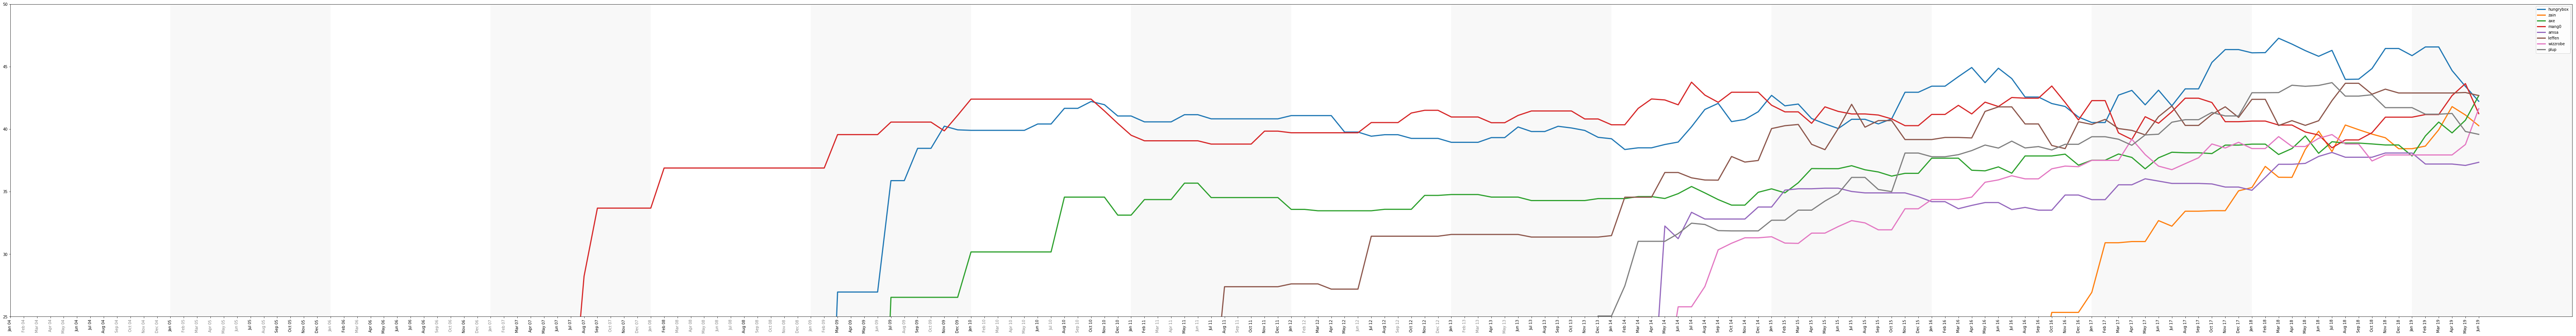

In [10]:
early = ["ken", "azen", "isai", "chudat", "captain jack", "recipherus", "sastopher", "wes", "neo"]
golden = ["ken", "azen", "isai", "chudat", "koreandj", "pc chris", "mew2king"]
gods = ["mang0", "armada", "hungrybox", "mew2king", "ppmd"]
slayers = ["leffen", "plup", "axe", "chudat", "wizzrobe", "wobbles", \
           "sfat", "lucky", "zain", "westballz"]
june_19 = ["mang0", "hungrybox", "leffen", "plup", "wizzrobe", "zain", "axe", "amsa"]

florida = ["hungrybox", "mew2king", "plup", "wizzrobe", "colbol", "gahtzu", "drunksloth", "king momo"]
socal = ["mang0", "s2j", "lucky", "hugs", "westballz", "army", "sfat", "captain faceroll"]
europe = ["armada", "leffen", "ice", "trif", "overtriforce", "professor pro", "amsah"]
midwest = ["duck", "absentpage", "kjh", "ginger", "michael", "abate", "prince abu", "drephen"]
norcal = ["darkatma", "pewpewu", "shroomed", "kalamazhu", "rocky", "spark", "nmw", "dizzkidboogie"]
tristate = ["swedish delight", "the moon", "captain smuckers", "2saint", "ibdw", "hax", "slox", "rishi"]
mdva = ["zain", "llod", "junebug", "chudat", "milkman", "jerry", "milkman", "bobby big ballz"]

graph_history(history, june_19)

# 4a) Predicting top 8s (simulation functions)

In [11]:
def win_prob(player_1, player_2):
    """ Calculate player 1's probability of winning the match.
    
        ARGS:
        - player_1:       (Rating)       : Trueskill rating of player 1. 
        - player_2:       (Rating)       : Trueskill rating of player 2. 
        
        RETURNS:
        - prob            (float)        : Between 0.0 to 1.0.
    """
    delta_mu = player_1.mu - player_2.mu
    sum_sigma = player_1.sigma ** 2 + player_2.sigma ** 2
    denom = math.sqrt(2 * trueskill.BETA * trueskill.BETA + sum_sigma)
    ts = trueskill.global_env()
    prob = ts.cdf(delta_mu / denom)
    return prob


def simulate_set(player_1, player_2, ratings, best_of_N):
    """ Simulate one set of match and determine who is the winner.
    
        ARGS:
        - player_1:       (str)          : Name of player 1. 
        - player_2:       (str)          : Name of player 2. 
        - ratings         (dict of str)  : Maps names to trueskill ratings.
        - best_of_N       (int)          : Best out of N matches.
        
        RETURNS:
        - winner          (str)          : Name of winner.
        - loser           (str)          : Name of loser.
    """
    # Set counts.
    set_count = { player_1:0, player_2:0 }
    set_count_win_num = (best_of_N // 2) + 1
    
    while True:
        
         # Get the probability that player1 wins the match.
        player_1_win_prob = win_prob(ratings[player_1], ratings[player_2])

        # Randomly determine if player1 wins based on player1_win.
        winner = player_1 if random.random() <= player_1_win_prob else player_2
        loser = player_2 if winner == player_1 else player_1
    
        # Adjust ratings and set count.
        ratings[winner], ratings[loser] = \
        trueskill.rate_1vs1(ratings[winner], ratings[loser])
        set_count[winner] += 1
        
        # Winner, Loser.
        if set_count[player_1] == set_count_win_num:
            return player_1, player_2
        elif set_count[player_2] == set_count_win_num:
            return player_2, player_1


def simulate_bracket(matches, ratings, best_of_N):
    """ Simulate a top 8 bracket.
    
        ARGS:
        - matches         (list of tuple): [(p1, p2), (p3, p4), ...]
        - ratings         (dict of str)  : Maps names to trueskill ratings.
        - best_of_N       (int)          : Best out of N matches.
        
        RETURNS:
        - results         (list of str)  : Results of the simulation.
    """
    middle = len(matches)/2
    winners, losers = matches[middle:], matches[:middle]
    
    winners_advance = []
    winners_to_losers = []
    losers_advance = []
    results = []

    # Losers Round N-1
    for match in losers:
        p1, p2 = match
        winner, loser = simulate_set(p1, p2, ratings, best_of_N)
        losers_advance.append(winner)
        results.append(loser)
    losers = []
    
    # Winners Semis
    for match in winners:
        p1, p2 = match
        winner, loser = simulate_set(p1, p2, ratings, best_of_N)
        winners_advance.append(winner)
        winners_to_losers.append(loser)
    winners = []
    
    # Calculation
    for i in range(len(losers_advance)):
        match = tuple([losers_advance[i], winners_to_losers[i]])
        losers.append(match)
    losers_advance = []
    winners_to_losers = []

    for i in range(len(winners_advance)/2):
        match = tuple([winners_advance[i], winners_advance[i+1]])
        winners.append(match)
    winners_advance = []

    # Losers Round N
    for match in losers:
        p1, p2 = match
        winner, loser = simulate_set(p1, p2, ratings, best_of_N)
        losers_advance.append(winner)
        results.append(loser)
    losers = []
    
    # Winners Finals
    for match in winners:
        p1, p2 = match
        winner, loser = simulate_set(p1, p2, ratings, best_of_N)
        winners_advance.append(winner)
        winners_to_losers.append(loser)
    winners = []
    
    # Calculation
    for i in range(len(losers_advance)/2):
        match = tuple([losers_advance[i], losers_advance[i+1]])
        losers.append(match)
    losers_advance = []
    
    # Losers Quarters
    for match in losers:
        p1, p2 = match
        winner, loser = simulate_set(p1, p2, ratings, best_of_N)
        losers_advance.append(winner)
        results.append(loser)
    losers = []
    
    # Losers Semis
    for i in range(len(losers_advance)):
        match = tuple([losers_advance[i], winners_to_losers[i]])
        losers.append(match)
    losers_advance = []
    winners_to_losers = []

    # Losers Finals
    for match in losers:
        p1, p2 = match
        winner, loser = simulate_set(p1, p2, ratings, best_of_N)
        losers_advance.append(winner)
        results.append(loser)
    losers = []

    # Grand Finals
    p1, p2 = winners_advance[0], losers_advance[0]
    winner, loser = simulate_set(p1, p2, ratings, best_of_N)
    if winner == p2:
        winner, loser = simulate_set(p1, p2, ratings, best_of_N)
    results.append(loser)
    results.append(winner)
    
    results.reverse()
    return results

# 4b) Predicting top 8s (prediction/graph functions)

In [12]:
def get_prediction(title, history, best_of_N = 5, num_simulations = 1000):
    """ Get probabilities of who places where in a top 8 bracket.
        
        ARGS
        - title           (str)          : Tournament to guess results.
        - history         (list of tuple): See get_history().
        - best of N       (int)          : What type of a set it is.
        - num_simulations (int)          : Number of bracket simulations.

        RETURNS:
        - prediction      (list of tuple): [ (names, [probabilities]), ... ]
    """
    # Search for the tournament before the given title.
    tournament_index = get_tournament_index(title, history)
    if tournament_index == -1:
        return None
    
    # Get top 8 matches and and player list
    matches, players = get_top_8(history[tournament_index][0])
    
    # Rate all matches up to top 8
    pred_ratings = get_pred_ratings(title, history)
    
    # Create a mini version of the ratings containing only the top 8 players
    mini_ratings = {}
    for name in players:
        mini_ratings[name] = pred_ratings[name]
        
    # Run a large number of simulations of the bracket.
    simulations = []
    for i in range(num_simulations):
        mini_ratings_cpy = copy.deepcopy(mini_ratings)
        result = simulate_bracket(matches, mini_ratings_cpy, best_of_N)
        simulations.append(result)
        
    # Count each player's simulated placing.
    player_placing_count = { p:[0]*6 for p in players }
    for row in simulations:
        for placing in range(len(row)):
            name = row[placing]
            if placing > 4:
                placing -= 1
            if placing == 6:
                placing -= 1
            player_placing_count[name][placing] += 1
    
    # Normalize.
    for player, placing_nums in player_placing_count.items():
        for i in range(len(placing_nums)):
            placing_nums[i] /= float(len(simulations))
    
    # Sort by most likely placing
    prediction = []
    for name in players:
        placings = player_placing_count[name]
        index = placings.index(max(placings))
        likelihood = max(placings)
        prediction.append((name, placings, index, 1-likelihood))
    prediction = sorted(prediction, key=lambda tup: (tup[2], tup[3]) )
    prediction = [(x[0], x[1]) for x in prediction]

    return prediction

def get_pred_ratings(title, history):
    """ Rate matches up until the top 8 bracket
        
        ARGS
        - title           (str)          : Tournament to guess results.
        - history         (list of tuple): See get_history().
        
        RETURNS:
        - pred_ratings    (list of Rate) : See trueskill API on Ratings.
    """
    # Get top 8 matches.
    tournament_index = get_tournament_index(title, history)
    matches, players = get_top_8(history[tournament_index][0])
    
    # Go to tournament dir path.
    date = history[tournament_index][0]["date"]
    folder_title = title.replace(" ", "-")
    month_day = date.strftime("%m%d")
    year = str(date.year)
    folder_name = month_day + "-" + folder_title
    folder_name = folder_name.replace("/", "-")
    src_path, data_path = get_src_data_paths()
    os.chdir(data_path)
    os.chdir(year)
    os.chdir(folder_name)
    
    # Get bracket matches.
    temp_bracket = []
    with open("bracket.csv", 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        temp_bracket = [row for row in csv_reader]
    temp_bracket = temp_bracket[:len(temp_bracket)-8]
    
    # Remove top 8 matches and beyond. 
    bracket = []
    winners = matches[len(matches)/2:]
    for match in temp_bracket:
        p1, p2 = match[0], match[1]
        if (p1, p2) not in winners:
            bracket.append(match)
    
    # Rate matches.
    ratings_cpy = copy.deepcopy(history[tournament_index-1][1])
    for row in bracket:
    
        # Get match information
        players = row[:2]
        set_count = row[2:4]
        stocks_left = row[4:]

        # Player not rated yet.
        for name in players:
            if name not in ratings_cpy.keys():
                ratings_cpy[name] = env.create_rating()

        # Rate match
        rate_match(ratings_cpy, players, set_count, stocks_left)
    
    return ratings_cpy

def graph_prediction(title, prediction, results = None, error = None):
    """ Plot a probability graph and table.
        
        ARGS
        - title           (str)          : Title of tournament.
        - prediction      (dict of list) : See get_prediction(...)
        - results         (list of str)  : See get_top_8(...)
        - error           (float)        : See compare_results(...)
        
    """
    # Make a copy of the results in case
    prediction_copy = copy.deepcopy(prediction)
    
    # Figure
    fig, ax, ax2 = None, None, None
    if results == None:
        fig, ax = plt.subplots(figsize = (15, 5))
        ax.axis("off")
    else:
        fig, (ax, ax2) = plt.subplots(1, 2, figsize = (15, 5), \
                         gridspec_kw = {'width_ratios': [5, 1]})
        ax.axis("off")
        ax2.axis("off")

    # Create prediction table text, colors, and column labels
    cell_text = []
    header_color = (1,1,1)
    cell_colors = [[(1,1,1)]*7]
    x_labels = [1, 2, 3, 4, 5, 7]
    for player, probabilities in prediction_copy:

        # Get table cell text
        cell_text.append(["{:.4f}".format(num) for num in probabilities])
        
        # Get table cell color (red/green based on probability %)
        best = max(probabilities)
        rgb = [ ( (best-i)/best, i/best, 0, 0.5 ) for i in probabilities ]
        rgb.insert(0, (1,1,1))
        cell_colors.append(rgb)
    
    # Add column labels for prediction table
    for i in range(len(cell_text)):
        cell_text[i].insert(0, prediction_copy[i][0])
    cell_text.insert(0, ["player", "1st", "2nd", "3rd", "4th", "5th", "7th"])
    
    # Create prediction table
    col_widths = [0.135, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
    #loc = "center" if results == None else "left"
    prob_table = ax.table(cellText = cell_text, cellColours = cell_colors, \
                           colWidths = col_widths, loc = "center")
    prob_table.set_fontsize(15)
    prob_table.scale(1.5, 2)
    
    # Results table
    if results:
        results_text = [["Place", "Player"]]
        for i in range(len(results)):
            results_text.append([str(i+1), results[i]])
        col_widths = [0.3, 0.7]
        results_table = ax2.table(cellText = results_text,
                               colWidths = col_widths, loc = "center")
        results_table.set_fontsize(15)
        results_table.scale(1.5, 2)
        error_txt = ""
        if error:
            error_txt = "(" + str(error)[:5] + " error)"
        ax2.set_title("Actual results " + error_txt, fontsize = 20)
    
    # Show graph and table.
    ax.set_title("Predictions for " + title, fontsize = 20)
    fig.tight_layout()
    plt.show()

def get_tournament_index(title, history):
    """ Get the history index of the tournament's title

        ARGS:
        - title           (str)          : Tournament title.
        - history         (list of tuple): get_history(...)
        
        RETURNS:
        - i               (int)          : history[i]
    """
    for i, (tournament, rating) in enumerate(history):
        if tournament["title"] == title:
            return i
    return -1

def get_top_8(tournament):
    """ Get the top 8 matches and results of a tournament

        ARGS:
        - tournament      (dict of str)  : Tournament info.
        
        RETURNS:
        - matches         (list of tuple): Top 8 matches.
        - results         (list of str)  : Results.
    """
    # Go to data directory
    src_path, data_path = get_src_data_paths()
    os.chdir(data_path)
    
    # Go to tournament's data directory
    folder_title = tournament["title"].replace(" ", "-")
    month_day = tournament["date"].strftime("%m%d")
    year = str(tournament["date"].year)
    folder_name = month_day + "-" + folder_title
    folder_name = folder_name.replace("/", "-")
    os.chdir(year)
    os.chdir(folder_name)

    # Get matches from the bracket csv file.
    matches = []
    with open("bracket.csv", 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        matches = [row for row in csv_reader]

    # Bad bracket
    if len(matches) <= 8:
        return None, None
    
    # Get top 8 matches
    top_8_matches = []
    for i in range(-7, -9, -1):
        match = (matches[i][0], matches[i][1])
        top_8_matches.append(match)
    winners = [matches[-4][0], matches[-4][1]]
    for i in range(-5, len(matches)*-1, -1):
        for name in winners:
            if name == matches[i][0] or name == matches[i][1]:
                match = (matches[i][0], matches[i][1])
                top_8_matches.append(match)
                winners.remove(name)
        if len(winners) == 0:
            break

    # Get results
    top_8_results = []
    for i in range(len(matches)-1, len(matches)-9, -1):
        p1, p2, s1, s2 = matches[i][:4]
        winner = p1 if s1 > s2 else p2
        loser = p2 if s1 > s2 else p1
        if winner not in top_8_results:
            top_8_results.append(winner)
        if loser not in top_8_results:
            top_8_results.append(loser)
            
    # Return to original src directory
    os.chdir(src_path)
    return top_8_matches, top_8_results

# 4c) Predicting Top 8s

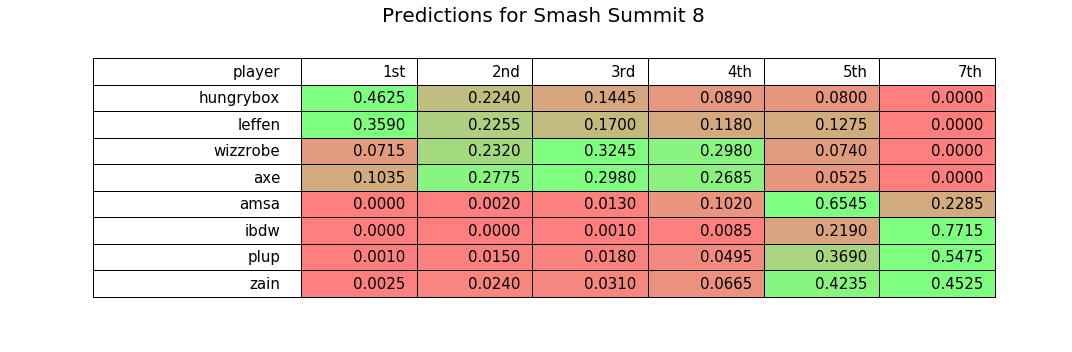

In [13]:
title = "Smash Summit 8"

prediction = get_prediction(title, history, num_simulations = 2000)
graph_prediction(title, prediction, )


# 5a) Error evaluation (functions)

In [14]:
def compare_results(prediction, actual_results):
    """ Get the error between two top 8 results.

        ARGS:
        - prediction      (list of tuple): See get_prediction(...)
        - actual_results  (list of str)  : See get_top_8(...)

        RETURNS:
        - error           (float)        : Percentage error.
    """
    pred_results = []
    for name, placings in prediction:
        placing = placings.index(max(placings))
        pred_results.append((placing + 1, name))
    pred_results = sorted(pred_results, key = lambda x: x[0])
    pred_results = [name for placing, name in pred_results]
    
    # Convert results into numbers
    name_to_int = {}
    placings = [1, 2, 3, 4, 5, 5, 7, 7]
    for i in range(len(placings)):
        name_to_int[pred_results[i]] = placings[i]
    
    pred_int = [name_to_int[n] for n in pred_results]
    actual_int = [name_to_int[n] for n in actual_results]
    
    # Error by average of wrong value per index
    pred_int = np.array(pred_int)
    actual_int = np.array(actual_int)
    error = np.mean( pred_int != actual_int )

    return error


# 5b) Error evaluation

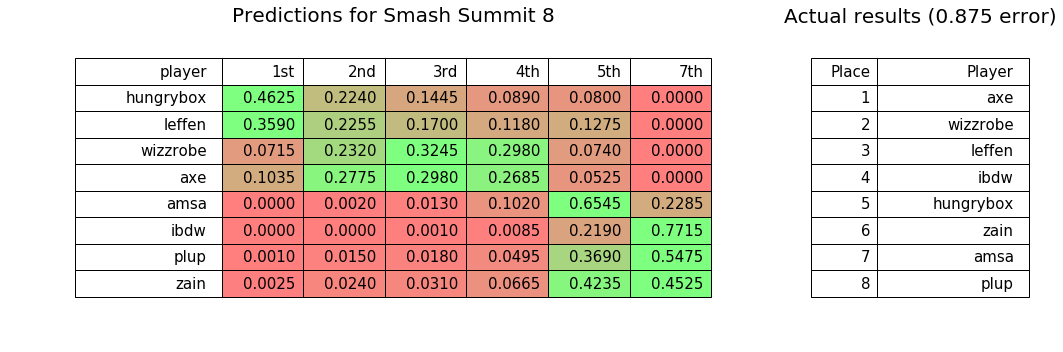

In [15]:
tournament_index = get_tournament_index(title, history)
pred_tournament = history[tournament_index][0]
matches, results = get_top_8(pred_tournament)
error = compare_results(prediction, results) 
graph_prediction(title, prediction, results, error)


# 5c) Error evaluation (of the most recent 10% of history)

0.569852941176


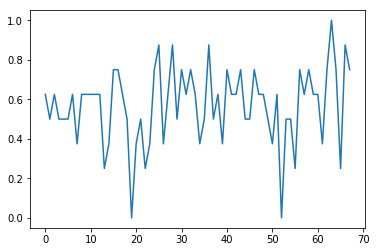

CPU times: user 8min 47s, sys: 1.04 s, total: 8min 48s
Wall time: 8min 48s


In [16]:
%%time
validation_index = int(len(history) - len(history) * 0.1)
validation = history[validation_index:]

errors = []
for tournament, rating in validation:
    title = tournament["title"]
    matches, results = get_top_8(tournament)
    if matches != None and results != None:
        prediction = get_prediction(title, history, 5, 500)
        error = compare_results(prediction, results)
        errors.append(error)

print(sum(errors)/len(errors))
plt.plot(errors)
plt.show()
